In [1]:
!pip install segmentation-models-pytorch --quiet

import segmentation_models_pytorch as smp
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = smp.Unet(
    encoder_name="resnet34",        
    encoder_weights="imagenet",     
    in_channels=3,                  
    classes=1,                     
)

model.to(device)
print("Pre-trained UNet with ResNet34 backbone loaded.")

c:\Users\ilaki\anaconda3\envs\sih_segmentation\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda
Pre-trained UNet with ResNet34 backbone loaded.


In [2]:
import os
import numpy as np
from PIL import Image
from pycocotools.coco import COCO

ann_dir = r"C:\Users\ilaki\Desktop\VISON_AI\coco2017\annotations"
img_dir = r"C:\Users\ilaki\Desktop\VISON_AI\coco2017\val2017"
out_mask_dir = r"C:\Users\ilaki\Desktop\VISON_AI\coco2017\BinaryMasks"
os.makedirs(out_mask_dir, exist_ok=True)

json_files = [f for f in os.listdir(ann_dir) if f.endswith(".json")]

for json_file in json_files:
    ann_path = os.path.join(ann_dir, json_file)
    coco = COCO(ann_path)

    img_ids = coco.getImgIds()
    for img_id in img_ids:
        img_info = coco.loadImgs(img_id)[0]
        anns = coco.loadAnns(coco.getAnnIds(imgIds=img_id))

        mask = np.zeros((img_info["height"], img_info["width"]), dtype=np.uint8)
        for ann in anns:
            if 'segmentation' in ann and ann['segmentation']:
                mask = np.maximum(mask, coco.annToMask(ann) * 255)

        mask_img = Image.fromarray(mask)
        mask_name = img_info['file_name'].replace(".jpg", ".png")
        mask_img.save(os.path.join(out_mask_dir, mask_name))

print("Mask generation completed!")


loading annotations into memory...
Done (t=3.55s)
creating index...
index created!
loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
loading annotations into memory...
Done (t=14.22s)
creating index...
index created!
loading annotations into memory...
Done (t=2.66s)
creating index...
index created!
loading annotations into memory...
Done (t=5.75s)
creating index...
index created!
loading annotations into memory...
Done (t=0.23s)
creating index...
index created!
Mask generation completed!


In [1]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import os
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

images_dir = r"C:\Users\ilaki\Desktop\VISON_AI\coco2017\val2017"
masks_dir = r"C:\Users\ilaki\Desktop\VISON_AI\coco2017\BinaryMasks"

class SegmentationDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform_img=None, transform_mask=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.image_files = sorted([f for f in os.listdir(images_dir) if f.endswith(".jpg")])
        self.mask_files = set([f for f in os.listdir(masks_dir) if f.endswith(".png")])
        self.valid_pairs = [(img, img.replace(".jpg", ".png")) for img in self.image_files
                            if img.replace(".jpg", ".png") in self.mask_files]
        self.transform_img = transform_img
        self.transform_mask = transform_mask
        print(f"Dataset initialized with {len(self.valid_pairs)} image-mask pairs.")

    def __len__(self):
        return len(self.valid_pairs)

    def __getitem__(self, idx):
        img_name, mask_name = self.valid_pairs[idx]
        img_path = os.path.join(self.images_dir, img_name)
        mask_path = os.path.join(self.masks_dir, mask_name)
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")
        if self.transform_img:
            image = self.transform_img(image)
        if self.transform_mask:
            mask = self.transform_mask(mask)
            mask = (mask > 0).float()
        return image, mask

transform_img = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])
transform_mask = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

dataset = SegmentationDataset(images_dir, masks_dir, transform_img=transform_img, transform_mask=transform_mask)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=0, pin_memory=True)

print("Loading a single epoch to check speed...")
for images, masks in tqdm(train_loader, desc="Training batches"):
    pass

print("Loader working ✅")


Dataset initialized with 5000 image-mask pairs.
Loading a single epoch to check speed...


Training batches: 100%|██████████| 1000/1000 [00:54<00:00, 18.36it/s]

Loader working ✅


In [2]:
import torch
import torch.nn as nn
from torchvision.models.segmentation import deeplabv3_resnet50, DeepLabV3_ResNet50_Weights

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = deeplabv3_resnet50(weights=DeepLabV3_ResNet50_Weights.DEFAULT)
model.classifier[4] = nn.Conv2d(256, 1, kernel_size=1)

model.to(device)


Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to C:\Users\ilaki/.cache\torch\hub\checkpoints\deeplabv3_resnet50_coco-cd0a2569.pth
100%|██████████| 161M/161M [00:52<00:00, 3.21MB/s] 


DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
num_epochs = 50
scaler = torch.cuda.amp.GradScaler()

def freeze_backbone(model, freeze=True):
    for param in model.backbone.parameters():
        param.requires_grad = not freeze

freeze_backbone(model, freeze=True)

def train_and_validate(model, train_loader, val_loader, criterion, optimizer, num_epochs, device, checkpoint_interval=5):
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for images, masks in train_loader:
            images, masks = images.to(device), masks.to(device)
            optimizer.zero_grad()
            with torch.cuda.amp.autocast():
                outputs = model(images)["out"]
                loss = criterion(outputs, masks)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            train_loss += loss.item() * images.size(0)
        avg_train_loss = train_loss / len(train_loader.dataset)
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device)
                with torch.cuda.amp.autocast():
                    outputs = model(images)["out"]
                    loss = criterion(outputs, masks)
                val_loss += loss.item() * images.size(0)
        avg_val_loss = val_loss / len(val_loader.dataset)
        print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
        if (epoch + 1) % checkpoint_interval == 0:
            torch.save(model.state_dict(), f"deeplabv3_epoch{epoch+1}.pth")
        if epoch + 1 == 5:
            freeze_backbone(model, freeze=False)
    return model

trained_model = train_and_validate(model, train_loader, val_loader, criterion, optimizer, num_epochs, device)
torch.save(trained_model.state_dict(), "deeplabv3_binary_50epochs_final.pth")


C:\Users\ilaki\AppData\Local\Temp\ipykernel_28444\446030903.py:9: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
C:\Users\ilaki\AppData\Local\Temp\ipykernel_28444\446030903.py:24: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
C:\Users\ilaki\AppData\Local\Temp\ipykernel_28444\446030903.py:37: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch [1/50] - Train Loss: 0.1634, Val Loss: 0.1294
Epoch [2/50] - Train Loss: 0.1435, Val Loss: 0.1203
Epoch [3/50] - Train Loss: 0.1391, Val Loss: 0.1133
Epoch [4/50] - Train Loss: 0.1332, Val Loss: 0.1300
Epoch [5/50] - Train Loss: 0.1320, Val Loss: 0.1156
Epoch [6/50] - Train Loss: 0.1379, Val Loss: 0.1021
Epoch [7/50] - Train Loss: 0.1136, Val Loss: 0.0993
Epoch [8/50] - Train Loss: 0.0987, Val Loss: 0.1040
Epoch [9/50] - Train Loss: 0.0960, Val Loss: 0.1217
Epoch [10/50] - Train Loss: 0.0756, Val Loss: 0.1083
Epoch [11/50] - Train Loss: 0.0732, Val Loss: 0.1023
Epoch [12/50] - Train Loss: 0.0754, Val Loss: 0.1252
Epoch [13/50] - Train Loss: 0.0683, Val Loss: 0.0904
Epoch [14/50] - Train Loss: 0.0509, Val Loss: 0.0936
Epoch [15/50] - Train Loss: 0.0725, Val Loss: 0.1090
Epoch [16/50] - Train Loss: 0.0618, Val Loss: 0.0975
Epoch [17/50] - Train Loss: 0.0488, Val Loss: 0.0928
Epoch [18/50] - Train Loss: 0.0438, Val Loss: 0.1044
Epoch [19/50] - Train Loss: 0.0514, Val Loss: 0.1064
Ep

KeyboardInterrupt: 

C:\Users\ilaki\AppData\Local\Temp\ipykernel_28444\2719852956.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(checkpoint_path, map_location=devic

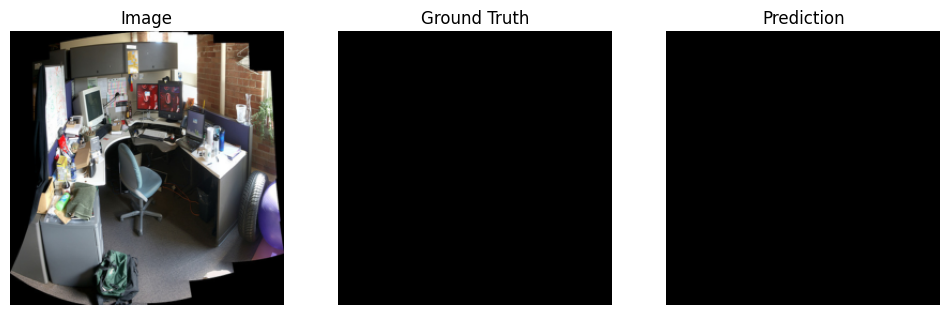

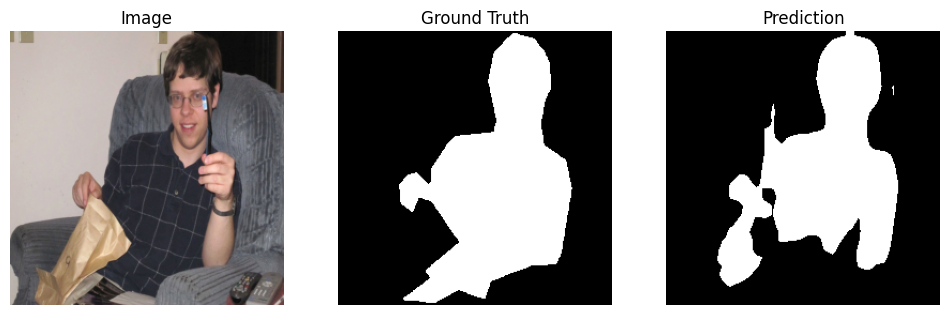

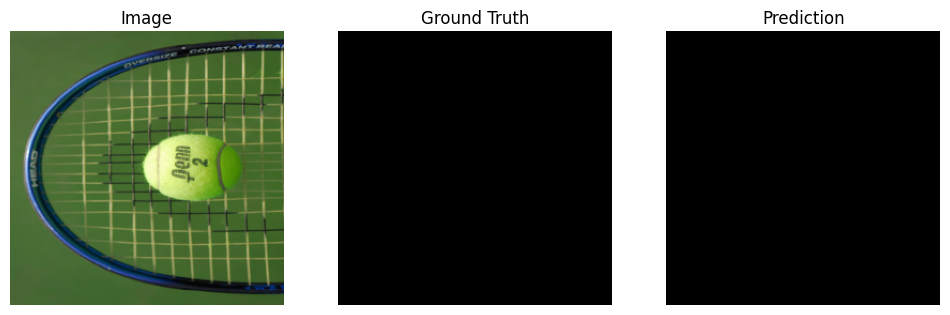

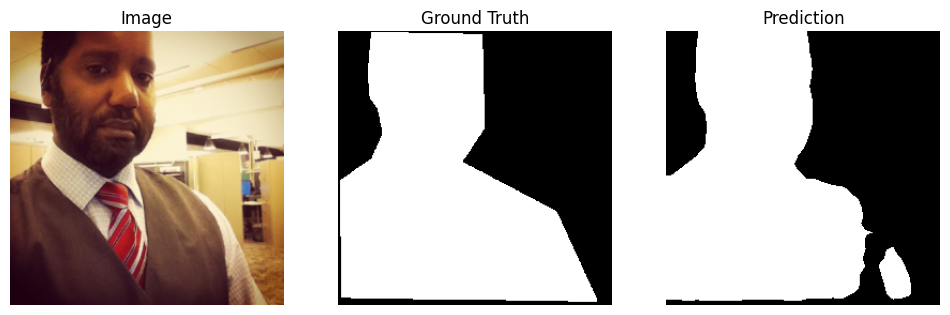

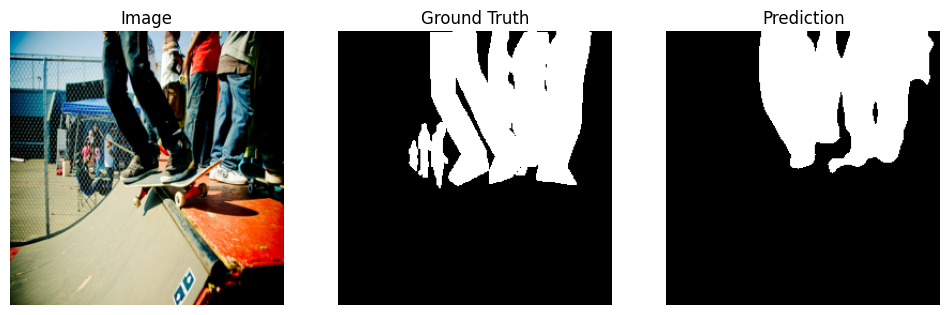

In [7]:
import torch
import matplotlib.pyplot as plt
import torchvision.models.segmentation as models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.deeplabv3_resnet50(pretrained=False, num_classes=1, aux_loss=False)
model.to(device)

checkpoint_path = "deeplabv3_epoch20.pth"
state_dict = torch.load(checkpoint_path, map_location=device)

state_dict = {k: v for k, v in state_dict.items() if "aux_classifier" not in k}
model.load_state_dict(state_dict, strict=False)

def evaluate_and_visualize(model, val_loader, device, num_samples=3):
    model.eval()
    samples = 0
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)["out"]
            preds = torch.sigmoid(outputs) > 0.5
            for i in range(images.size(0)):
                if samples >= num_samples:
                    return
                img = images[i].cpu().permute(1, 2, 0).numpy()
                gt = masks[i].cpu().squeeze().numpy()
                pred = preds[i].cpu().squeeze().numpy()
                fig, axs = plt.subplots(1, 3, figsize=(12, 4))
                axs[0].imshow(img)
                axs[0].set_title("Image")
                axs[1].imshow(gt, cmap="gray")
                axs[1].set_title("Ground Truth")
                axs[2].imshow(pred, cmap="gray")
                axs[2].set_title("Prediction")
                for ax in axs:
                    ax.axis("off")
                plt.show()
                samples += 1

evaluate_and_visualize(model, val_loader, device, num_samples=5)


In [17]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchvision.models.segmentation import deeplabv3_resnet50, DeepLabV3_ResNet50_Weights
from skimage.draw import polygon
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Hyperparameters
num_epochs = 5
batch_size = 6
learning_rate = 1e-4
weight_decay = 1e-5
image_size = 256
num_classes = 2
checkpoint_path = "deeplabv3_epoch20.pth"  # your previous checkpoint

# Dataset class
class CocoMaskedDataset(Dataset):
    def __init__(self, images_path, annotations_path, transform=None):
        self.images_path = images_path
        self.transform = transform
        import json
        with open(annotations_path, "r") as f:
            coco = json.load(f)
        self.images = {img["id"]: img["file_name"] for img in coco["images"]}
        self.annotations = {}
        for ann in coco["annotations"]:
            img_id = ann["image_id"]
            if img_id not in self.annotations:
                self.annotations[img_id] = []
            self.annotations[img_id].append(ann)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_id = list(self.images.keys())[idx]
        img_path = os.path.join(self.images_path, self.images[img_id])
        img = np.array(Image.open(img_path).convert("RGB"))
        mask = np.zeros(img.shape[:2], dtype=np.uint8)
        anns = self.annotations.get(img_id, [])
        for ann in anns:
            for seg in ann["segmentation"]:
                if isinstance(seg, list) and len(seg) % 2 == 0:
                    poly = np.array(seg).reshape(-1, 2)
                    rr, cc = polygon(poly[:, 1], poly[:, 0], shape=img.shape[:2])
                    mask[rr, cc] = 1
        if self.transform:
            augmented = self.transform(image=img, mask=mask)
            img = augmented["image"]
            mask = augmented["mask"]
        return img, mask.long()

# Transforms
train_transform = A.Compose([
    A.Resize(image_size, image_size),
    A.HorizontalFlip(p=0.5),
    A.ColorJitter(p=0.3),
    A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
    ToTensorV2()
])
val_transform = A.Compose([
    A.Resize(image_size, image_size),
    A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
    ToTensorV2()
])

# Paths
images_path = r"C:\Users\ilaki\Desktop\VISON_AI\coco2017\val2017"
annotations_path = r"C:\Users\ilaki\Desktop\VISON_AI\coco2017\annotations\instances_val2017.json"

dataset = CocoMaskedDataset(images_path, annotations_path, transform=train_transform)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
val_dataset.dataset.transform = val_transform

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

# Model
weights = DeepLabV3_ResNet50_Weights.DEFAULT
model = deeplabv3_resnet50(weights=weights, aux_loss=True)
model.classifier[4] = nn.Conv2d(256, num_classes, kernel_size=1)
model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scaler = torch.cuda.amp.GradScaler()

# Freeze backbone initially
def freeze_backbone(model, freeze=True):
    for param in model.backbone.parameters():
        param.requires_grad = not freeze

freeze_backbone(model, freeze=True)

# Load checkpoint (ignore classifier weights)
checkpoint = torch.load(checkpoint_path, map_location=device)
model_dict = model.state_dict()
filtered_dict = {k: v for k, v in checkpoint.items() if "classifier.4" not in k}
model_dict.update(filtered_dict)
model.load_state_dict(model_dict)
print("Checkpoint loaded, classifier head reinitialized for new num_classes.")

# Training function
def train_resume(model, train_loader, val_loader, criterion, optimizer, num_epochs, device, start_epoch=21, checkpoint_interval=5):
    best_val_loss = float("inf")
    backbone_unfrozen = False
    for epoch in range(start_epoch, start_epoch + num_epochs):
        model.train()
        train_loss = 0.0
        for images, masks in tqdm(train_loader, desc=f"Epoch {epoch}/{start_epoch+num_epochs-1} [Training]", leave=False):
            images, masks = images.to(device), masks.to(device)
            optimizer.zero_grad()
            with torch.cuda.amp.autocast():
                outputs = model(images)["out"]
                loss = criterion(outputs, masks)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            train_loss += loss.item() * images.size(0)
        avg_train_loss = train_loss / len(train_loader.dataset)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device)
                with torch.cuda.amp.autocast():
                    outputs = model(images)["out"]
                    loss = criterion(outputs, masks)
                val_loss += loss.item() * images.size(0)
        avg_val_loss = val_loss / len(val_loader.dataset)

        print(f"Epoch [{epoch}/{start_epoch+num_epochs-1}] - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), f"deeplabv3_resumed_best.pth")
            print("Best model updated!")

        # Unfreeze backbone after first epoch
        if not backbone_unfrozen:
            freeze_backbone(model, freeze=False)
            backbone_unfrozen = True
            print("Backbone unfrozen, fine-tuning full model!")

        # Save checkpoint
        if (epoch - start_epoch + 1) % checkpoint_interval == 0:
            torch.save(model.state_dict(), f"deeplabv3_resumed_epoch{epoch}.pth")

    return model

# Run resumed training
trained_model = train_resume(model, train_loader, val_loader, criterion, optimizer, num_epochs, device)
torch.save(trained_model.state_dict(), "deeplabv3_resumed_final.pth")
print("Resumed training complete!")


Using device: cuda


C:\Users\ilaki\AppData\Local\Temp\ipykernel_19788\1525284425.py:99: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
C:\Users\ilaki\AppData\Local\Temp\ipykernel_19788\1525284425.py:109: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `

Checkpoint loaded, classifier head reinitialized for new num_classes.


Epoch 21/25 [Training]:   0%|          | 0/667 [00:00<?, ?it/s]C:\Users\ilaki\AppData\Local\Temp\ipykernel_19788\1525284425.py:126: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
C:\Users\ilaki\AppData\Local\Temp\ipykernel_19788\1525284425.py:140: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch [21/25] - Train Loss: 0.4129, Val Loss: 0.3548
Best model updated!
Backbone unfrozen, fine-tuning full model!


Epoch [22/25] - Train Loss: 0.3452, Val Loss: 0.3004
Best model updated!


Epoch [23/25] - Train Loss: 0.2934, Val Loss: 0.2950
Best model updated!


Epoch [24/25] - Train Loss: 0.2548, Val Loss: 0.3051


Epoch [25/25] - Train Loss: 0.2216, Val Loss: 0.3032
Resumed training complete!


Mean IoU: 0.7205, Mean Dice: 0.8271, Pixel Accuracy: 0.8683


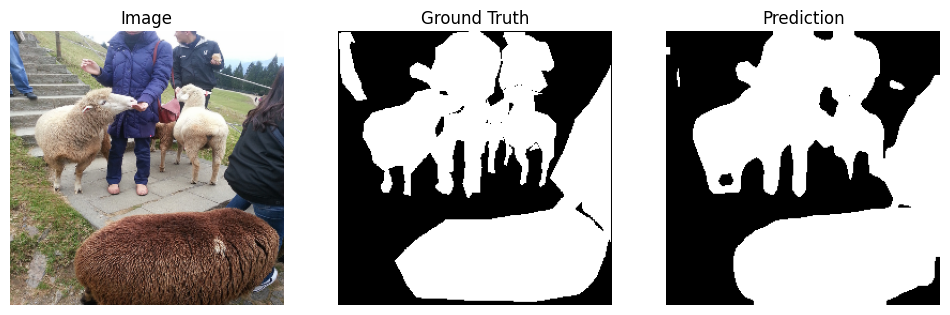

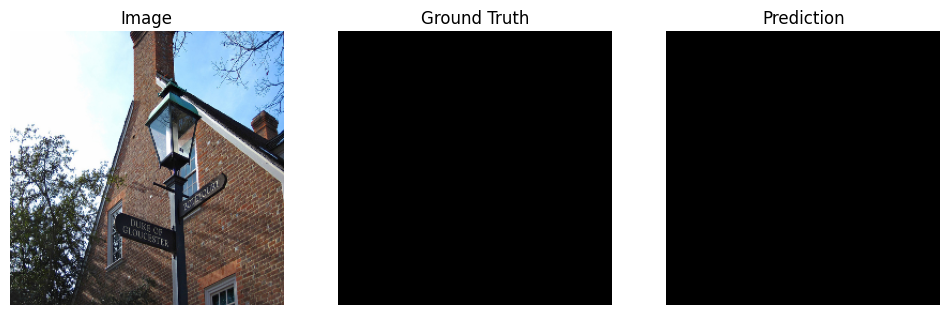

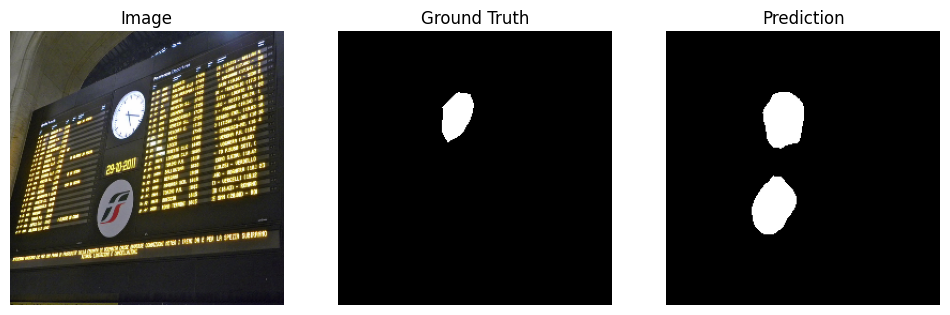

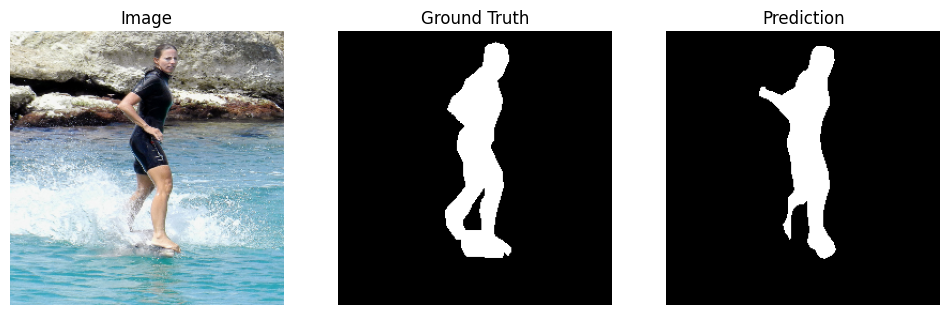

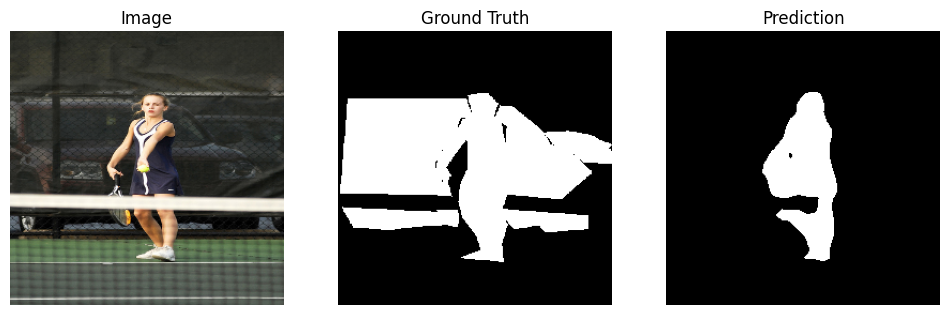

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import torch

def iou_score(preds, masks, num_classes=2):
    preds = torch.argmax(preds, dim=1)
    ious = []
    for cls in range(num_classes):
        pred_inds = (preds == cls)
        target_inds = (masks == cls)
        intersection = (pred_inds & target_inds).sum().float()
        union = (pred_inds | target_inds).sum().float()
        ious.append((intersection / union).item() if union != 0 else float('nan'))
    return np.nanmean(ious)

def dice_score(preds, masks, num_classes=2):
    preds = torch.argmax(preds, dim=1)
    dices = []
    for cls in range(num_classes):
        pred_inds = (preds == cls)
        target_inds = (masks == cls)
        intersection = (pred_inds & target_inds).sum().float() * 2
        denominator = pred_inds.sum().float() + target_inds.sum().float()
        dices.append((intersection / denominator).item() if denominator != 0 else float('nan'))
    return np.nanmean(dices)

def pixel_accuracy(preds, masks):
    preds = torch.argmax(preds, dim=1)
    correct = (preds == masks).sum().float()
    total = torch.numel(masks)
    return (correct / total).item()

def evaluate_model(model, dataloader, device):
    model.eval()
    metrics = {"IoU": [], "Dice": [], "PixelAcc": []}
    with torch.no_grad():
        for imgs, masks in dataloader:
            imgs, masks = imgs.to(device), masks.to(device)
            outputs = model(imgs)["out"]
            metrics["IoU"].append(iou_score(outputs, masks))
            metrics["Dice"].append(dice_score(outputs, masks))
            metrics["PixelAcc"].append(pixel_accuracy(outputs, masks))
    print(f"Mean IoU: {np.mean(metrics['IoU']):.4f}, Mean Dice: {np.mean(metrics['Dice']):.4f}, Pixel Accuracy: {np.mean(metrics['PixelAcc']):.4f}")

# Prediction & Visualization
def visualize_predictions(model, dataloader, device, num_samples=5):
    model.eval()
    samples = 0
    with torch.no_grad():
        for imgs, masks in dataloader:
            imgs = imgs.to(device)
            outputs = model(imgs)["out"]
            preds = torch.argmax(outputs, dim=1).cpu()
            
            for i in range(imgs.size(0)):
                img = imgs[i].cpu().permute(1, 2, 0).numpy()
                # un-normalize
                img = np.clip(img * (0.229, 0.224, 0.225) + (0.485, 0.456, 0.406), 0, 1)
                mask_gt = masks[i].cpu().numpy()
                mask_pred = preds[i].numpy()
                
                fig, axs = plt.subplots(1, 3, figsize=(12, 4))
                axs[0].imshow(img); axs[0].set_title("Image"); axs[0].axis("off")
                axs[1].imshow(mask_gt, cmap="gray"); axs[1].set_title("Ground Truth"); axs[1].axis("off")
                axs[2].imshow(mask_pred, cmap="gray"); axs[2].set_title("Prediction"); axs[2].axis("off")
                plt.show()
                
                samples += 1
                if samples >= num_samples:
                    return

# Run
evaluate_model(trained_model, val_loader, device)
visualize_predictions(trained_model, val_loader, device, num_samples=5)


Using device: cuda


C:\Users\ilaki\AppData\Local\Temp\ipykernel_30484\15928777.py:95: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
C:\Users\ilaki\AppData\Local\Temp\ipykernel_30484\15928777.py:104: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weig

Resuming training from epoch 26


Epoch 26/30 [Training]:   0%|          | 0/667 [00:00<?, ?it/s]C:\Users\ilaki\AppData\Local\Temp\ipykernel_30484\15928777.py:118: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
C:\Users\ilaki\AppData\Local\Temp\ipykernel_30484\15928777.py:132: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch [26/30] - Train Loss: 0.2148, Val Loss: 0.1898
Best model updated!
Backbone unfrozen, fine-tuning full model!


Epoch [27/30] - Train Loss: 0.2301, Val Loss: 0.2033


Epoch [28/30] - Train Loss: 0.1960, Val Loss: 0.2033


Epoch [29/30] - Train Loss: 0.1770, Val Loss: 0.2084


Epoch [30/30] - Train Loss: 0.1542, Val Loss: 0.2178
Additional 5 epochs completed!


C:\Users\ilaki\AppData\Local\Temp\ipykernel_30484\15928777.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Mean IoU: 0.8075204058075077
Mean Dice: 0.8917129142150892
Pixel Accuracy: 0.9101240634918213


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].


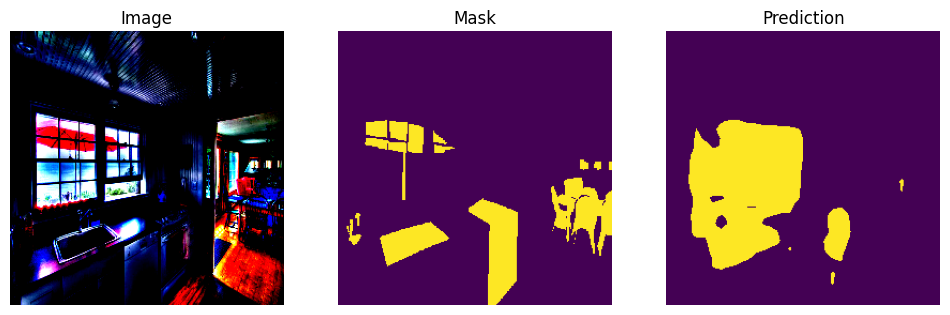

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.186841].


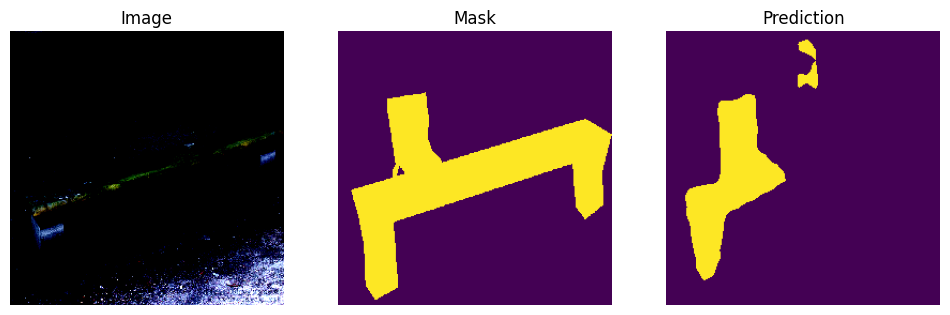

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0151553..2.6225708].


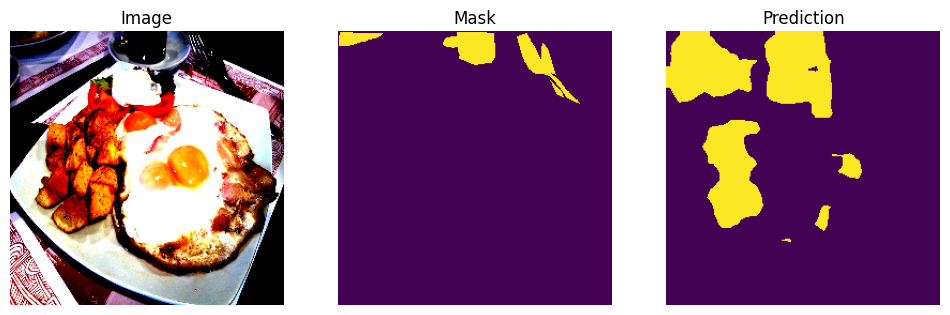

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].


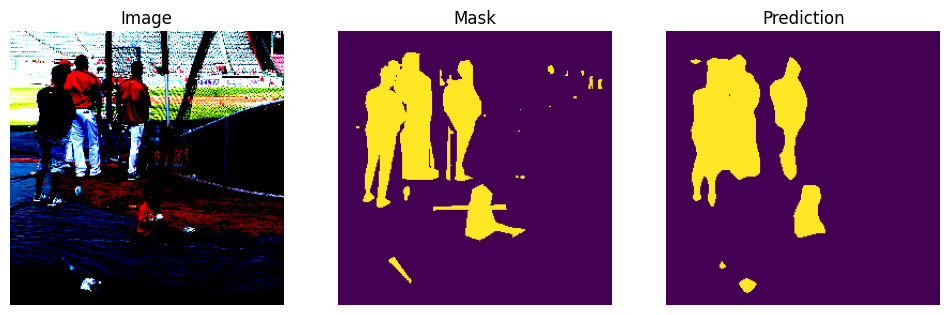

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchvision.models.segmentation import deeplabv3_resnet50, DeepLabV3_ResNet50_Weights
from skimage.draw import polygon
from tqdm import tqdm
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

num_epochs = 5           
start_epoch = 26        
batch_size = 6
learning_rate = 1e-4
weight_decay = 1e-5
image_size = 256
num_classes = 2
checkpoint_path = "deeplabv3_resumed_final.pth" 

class CocoMaskedDataset(Dataset):
    def __init__(self, images_path, annotations_path, transform=None):
        self.images_path = images_path
        self.transform = transform
        import json
        with open(annotations_path, "r") as f:
            coco = json.load(f)
        self.images = {img["id"]: img["file_name"] for img in coco["images"]}
        self.annotations = {}
        for ann in coco["annotations"]:
            img_id = ann["image_id"]
            if img_id not in self.annotations:
                self.annotations[img_id] = []
            self.annotations[img_id].append(ann)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_id = list(self.images.keys())[idx]
        img_path = os.path.join(self.images_path, self.images[img_id])
        img = np.array(Image.open(img_path).convert("RGB"))
        mask = np.zeros(img.shape[:2], dtype=np.uint8)
        anns = self.annotations.get(img_id, [])
        for ann in anns:
            for seg in ann["segmentation"]:
                if isinstance(seg, list) and len(seg) % 2 == 0:
                    poly = np.array(seg).reshape(-1, 2)
                    rr, cc = polygon(poly[:, 1], poly[:, 0], shape=img.shape[:2])
                    mask[rr, cc] = 1
        if self.transform:
            augmented = self.transform(image=img, mask=mask)
            img = augmented["image"]
            mask = augmented["mask"]
        return img, mask.long()

train_transform = A.Compose([
    A.Resize(image_size, image_size),
    A.HorizontalFlip(p=0.5),
    A.ColorJitter(p=0.3),
    A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
    ToTensorV2()
])
val_transform = A.Compose([
    A.Resize(image_size, image_size),
    A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
    ToTensorV2()
])

images_path = r"C:\Users\ilaki\Desktop\VISON_AI\coco2017\val2017"
annotations_path = r"C:\Users\ilaki\Desktop\VISON_AI\coco2017\annotations\instances_val2017.json"

dataset = CocoMaskedDataset(images_path, annotations_path, transform=train_transform)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
val_dataset.dataset.transform = val_transform

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

weights = DeepLabV3_ResNet50_Weights.DEFAULT
model = deeplabv3_resnet50(weights=weights, aux_loss=True)
model.classifier[4] = nn.Conv2d(256, num_classes, kernel_size=1)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scaler = torch.cuda.amp.GradScaler()

def freeze_backbone(model, freeze=True):
    for param in model.backbone.parameters():
        param.requires_grad = not freeze

freeze_backbone(model, freeze=True)

# Load checkpoint
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint)
print(f"Resuming training from epoch {start_epoch}")

# Training function
def train_resume(model, train_loader, val_loader, criterion, optimizer, num_epochs, device, start_epoch=26, checkpoint_interval=5):
    best_val_loss = float("inf")
    backbone_unfrozen = False
    for epoch in range(start_epoch, start_epoch + num_epochs):
        model.train()
        train_loss = 0.0
        for images, masks in tqdm(train_loader, desc=f"Epoch {epoch}/{start_epoch+num_epochs-1} [Training]", leave=False):
            images, masks = images.to(device), masks.to(device)
            optimizer.zero_grad()
            with torch.cuda.amp.autocast():
                outputs = model(images)["out"]
                loss = criterion(outputs, masks)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            train_loss += loss.item() * images.size(0)
        avg_train_loss = train_loss / len(train_loader.dataset)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device)
                with torch.cuda.amp.autocast():
                    outputs = model(images)["out"]
                    loss = criterion(outputs, masks)
                val_loss += loss.item() * images.size(0)
        avg_val_loss = val_loss / len(val_loader.dataset)

        print(f"Epoch [{epoch}/{start_epoch+num_epochs-1}] - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), f"deeplabv3_resumed_best.pth")
            print("Best model updated!")

        if not backbone_unfrozen:
            freeze_backbone(model, freeze=False)
            backbone_unfrozen = True
            print("Backbone unfrozen, fine-tuning full model!")

        if (epoch - start_epoch + 1) % checkpoint_interval == 0:
            torch.save(model.state_dict(), f"deeplabv3_resumed_epoch{epoch}.pth")
    return model

# Run resumed training
trained_model = train_resume(model, train_loader, val_loader, criterion, optimizer, num_epochs, device)
torch.save(trained_model.state_dict(), "deeplabv3_resumed_final_5more.pth")
print("Additional 5 epochs completed!")

# --- Evaluation Metrics & Prediction Visualization ---
def iou_score(preds, masks, num_classes=num_classes):
    preds = torch.argmax(preds, dim=1)
    ious = []
    for cls in range(num_classes):
        intersection = ((preds == cls) & (masks == cls)).sum().item()
        union = ((preds == cls) | (masks == cls)).sum().item()
        ious.append(intersection / (union + 1e-6))
    return np.mean(ious)

def dice_score(preds, masks, num_classes=num_classes):
    preds = torch.argmax(preds, dim=1)
    dices = []
    for cls in range(num_classes):
        intersection = ((preds == cls) & (masks == cls)).sum().item()
        total = (preds == cls).sum().item() + (masks == cls).sum().item()
        dices.append(2*intersection / (total + 1e-6))
    return np.mean(dices)

def pixel_accuracy(preds, masks):
    preds = torch.argmax(preds, dim=1)
    return (preds == masks).float().mean().item()

# Evaluate on validation set
trained_model.eval()
all_preds = []
all_masks = []
with torch.no_grad():
    for images, masks in val_loader:
        images, masks = images.to(device), masks.to(device)
        with torch.cuda.amp.autocast():
            outputs = trained_model(images)["out"]
        all_preds.append(outputs)
        all_masks.append(masks)
all_preds = torch.cat(all_preds)
all_masks = torch.cat(all_masks)

print("Mean IoU:", iou_score(all_preds, all_masks))
print("Mean Dice:", dice_score(all_preds, all_masks))
print("Pixel Accuracy:", pixel_accuracy(all_preds, all_masks))

# Visualize a few predictions
images, masks = next(iter(val_loader))
images, masks = images.to(device), masks.to(device)
with torch.no_grad():
    preds = trained_model(images)["out"]
preds = torch.argmax(preds, dim=1).cpu().numpy()
images = images.cpu().permute(0,2,3,1).numpy()
masks = masks.cpu().numpy()

for i in range(min(4, len(images))):
    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1)
    plt.title("Image")
    plt.imshow(images[i])
    plt.axis('off')
    plt.subplot(1,3,2)
    plt.title("Mask")
    plt.imshow(masks[i])
    plt.axis('off')
    plt.subplot(1,3,3)
    plt.title("Prediction")
    plt.imshow(preds[i])
    plt.axis('off')
    plt.show()


Using device: cuda


C:\Users\ilaki\AppData\Local\Temp\ipykernel_8384\1976278147.py:95: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
C:\Users\ilaki\AppData\Local\Temp\ipykernel_8384\1976278147.py:104: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `we

Resuming training from epoch 31


Epoch 26/30 [Training]:   0%|          | 0/667 [00:00<?, ?it/s]C:\Users\ilaki\AppData\Local\Temp\ipykernel_8384\1976278147.py:118: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
C:\Users\ilaki\AppData\Local\Temp\ipykernel_8384\1976278147.py:132: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch [26/30] - Train Loss: 0.1588, Val Loss: 0.1403
Best model updated!
Backbone unfrozen, fine-tuning full model!


Epoch [27/30] - Train Loss: 0.1677, Val Loss: 0.1520


Epoch [28/30] - Train Loss: 0.1435, Val Loss: 0.1499


Epoch [29/30] - Train Loss: 0.1360, Val Loss: 0.1630


Epoch [30/30] - Train Loss: 0.1254, Val Loss: 0.1736
Additional 5 epochs completed!


C:\Users\ilaki\AppData\Local\Temp\ipykernel_8384\1976278147.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Mean IoU: 0.837132080350665
Mean Dice: 0.9098231437199134
Pixel Accuracy: 0.9282413125038147


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].


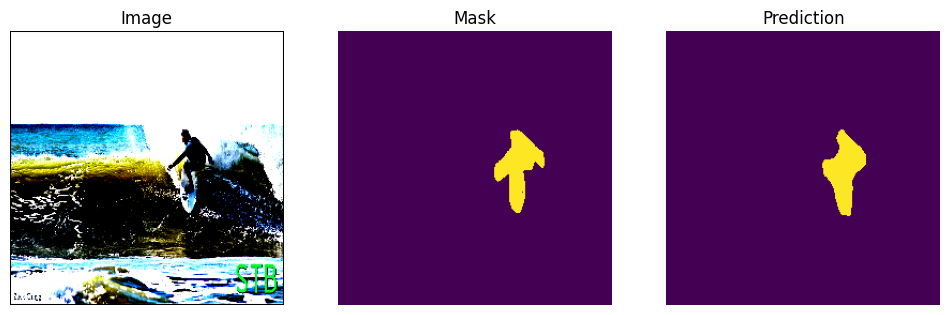

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].


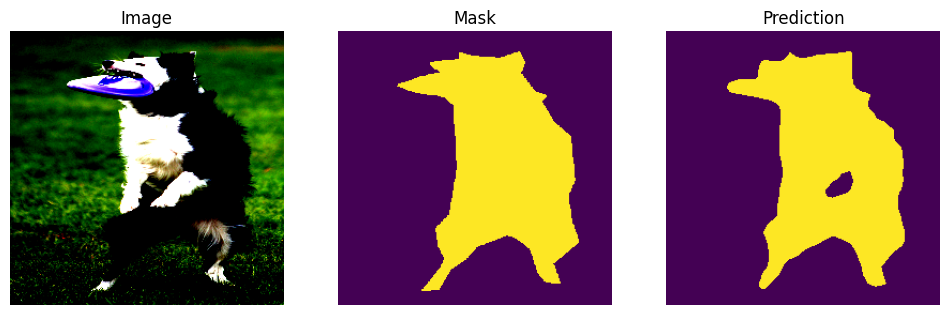

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].


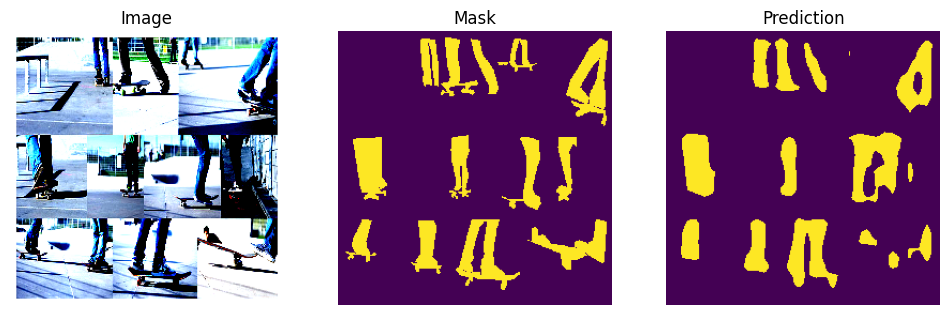

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6225708].


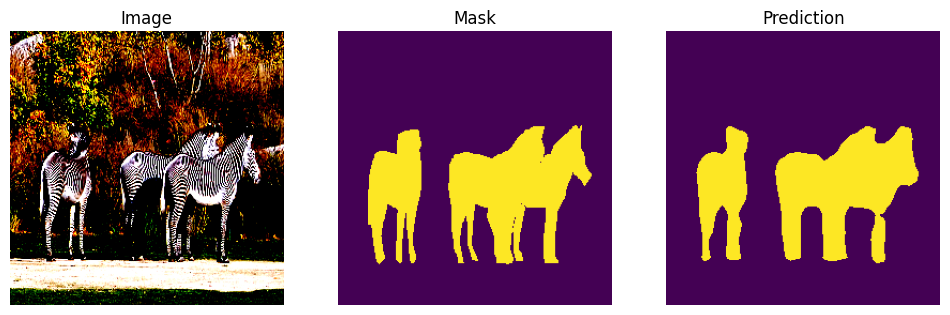

In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchvision.models.segmentation import deeplabv3_resnet50, DeepLabV3_ResNet50_Weights
from skimage.draw import polygon
from tqdm import tqdm
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

num_epochs = 5           
start_epoch = 31     
batch_size = 6
learning_rate = 1e-4
weight_decay = 1e-5
image_size = 256
num_classes = 2
checkpoint_path = "deeplabv3_resumed_final_5more.pth" 

class CocoMaskedDataset(Dataset):
    def __init__(self, images_path, annotations_path, transform=None):
        self.images_path = images_path
        self.transform = transform
        import json
        with open(annotations_path, "r") as f:
            coco = json.load(f)
        self.images = {img["id"]: img["file_name"] for img in coco["images"]}
        self.annotations = {}
        for ann in coco["annotations"]:
            img_id = ann["image_id"]
            if img_id not in self.annotations:
                self.annotations[img_id] = []
            self.annotations[img_id].append(ann)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_id = list(self.images.keys())[idx]
        img_path = os.path.join(self.images_path, self.images[img_id])
        img = np.array(Image.open(img_path).convert("RGB"))
        mask = np.zeros(img.shape[:2], dtype=np.uint8)
        anns = self.annotations.get(img_id, [])
        for ann in anns:
            for seg in ann["segmentation"]:
                if isinstance(seg, list) and len(seg) % 2 == 0:
                    poly = np.array(seg).reshape(-1, 2)
                    rr, cc = polygon(poly[:, 1], poly[:, 0], shape=img.shape[:2])
                    mask[rr, cc] = 1
        if self.transform:
            augmented = self.transform(image=img, mask=mask)
            img = augmented["image"]
            mask = augmented["mask"]
        return img, mask.long()

train_transform = A.Compose([
    A.Resize(image_size, image_size),
    A.HorizontalFlip(p=0.5),
    A.ColorJitter(p=0.3),
    A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
    ToTensorV2()
])
val_transform = A.Compose([
    A.Resize(image_size, image_size),
    A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
    ToTensorV2()
])

images_path = r"C:\Users\ilaki\Desktop\VISON_AI\coco2017\val2017"
annotations_path = r"C:\Users\ilaki\Desktop\VISON_AI\coco2017\annotations\instances_val2017.json"

dataset = CocoMaskedDataset(images_path, annotations_path, transform=train_transform)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
val_dataset.dataset.transform = val_transform

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

weights = DeepLabV3_ResNet50_Weights.DEFAULT
model = deeplabv3_resnet50(weights=weights, aux_loss=True)
model.classifier[4] = nn.Conv2d(256, num_classes, kernel_size=1)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scaler = torch.cuda.amp.GradScaler()

def freeze_backbone(model, freeze=True):
    for param in model.backbone.parameters():
        param.requires_grad = not freeze

freeze_backbone(model, freeze=True)

# Load checkpoint
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint)
print(f"Resuming training from epoch {start_epoch}")

# Training function
def train_resume(model, train_loader, val_loader, criterion, optimizer, num_epochs, device, start_epoch=26, checkpoint_interval=5):
    best_val_loss = float("inf")
    backbone_unfrozen = False
    for epoch in range(start_epoch, start_epoch + num_epochs):
        model.train()
        train_loss = 0.0
        for images, masks in tqdm(train_loader, desc=f"Epoch {epoch}/{start_epoch+num_epochs-1} [Training]", leave=False):
            images, masks = images.to(device), masks.to(device)
            optimizer.zero_grad()
            with torch.cuda.amp.autocast():
                outputs = model(images)["out"]
                loss = criterion(outputs, masks)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            train_loss += loss.item() * images.size(0)
        avg_train_loss = train_loss / len(train_loader.dataset)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device)
                with torch.cuda.amp.autocast():
                    outputs = model(images)["out"]
                    loss = criterion(outputs, masks)
                val_loss += loss.item() * images.size(0)
        avg_val_loss = val_loss / len(val_loader.dataset)

        print(f"Epoch [{epoch}/{start_epoch+num_epochs-1}] - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), f"deeplabv3_resumed_best.pth")
            print("Best model updated!")

        if not backbone_unfrozen:
            freeze_backbone(model, freeze=False)
            backbone_unfrozen = True
            print("Backbone unfrozen, fine-tuning full model!")

        if (epoch - start_epoch + 1) % checkpoint_interval == 0:
            torch.save(model.state_dict(), f"deeplabv3_resumed_epoch{epoch}.pth")
    return model

# Run resumed training
trained_model = train_resume(model, train_loader, val_loader, criterion, optimizer, num_epochs, device)
torch.save(trained_model.state_dict(), "deeplabv3_resumed_final_5more.pth")
print("Additional 5 epochs completed!")

# --- Evaluation Metrics & Prediction Visualization ---
def iou_score(preds, masks, num_classes=num_classes):
    preds = torch.argmax(preds, dim=1)
    ious = []
    for cls in range(num_classes):
        intersection = ((preds == cls) & (masks == cls)).sum().item()
        union = ((preds == cls) | (masks == cls)).sum().item()
        ious.append(intersection / (union + 1e-6))
    return np.mean(ious)

def dice_score(preds, masks, num_classes=num_classes):
    preds = torch.argmax(preds, dim=1)
    dices = []
    for cls in range(num_classes):
        intersection = ((preds == cls) & (masks == cls)).sum().item()
        total = (preds == cls).sum().item() + (masks == cls).sum().item()
        dices.append(2*intersection / (total + 1e-6))
    return np.mean(dices)

def pixel_accuracy(preds, masks):
    preds = torch.argmax(preds, dim=1)
    return (preds == masks).float().mean().item()

# Evaluate on validation set
trained_model.eval()
all_preds = []
all_masks = []
with torch.no_grad():
    for images, masks in val_loader:
        images, masks = images.to(device), masks.to(device)
        with torch.cuda.amp.autocast():
            outputs = trained_model(images)["out"]
        all_preds.append(outputs)
        all_masks.append(masks)
all_preds = torch.cat(all_preds)
all_masks = torch.cat(all_masks)

print("Mean IoU:", iou_score(all_preds, all_masks))
print("Mean Dice:", dice_score(all_preds, all_masks))
print("Pixel Accuracy:", pixel_accuracy(all_preds, all_masks))

# Visualize a few predictions
images, masks = next(iter(val_loader))
images, masks = images.to(device), masks.to(device)
with torch.no_grad():
    preds = trained_model(images)["out"]
preds = torch.argmax(preds, dim=1).cpu().numpy()
images = images.cpu().permute(0,2,3,1).numpy()
masks = masks.cpu().numpy()

for i in range(min(4, len(images))):
    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1)
    plt.title("Image")
    plt.imshow(images[i])
    plt.axis('off')
    plt.subplot(1,3,2)
    plt.title("Mask")
    plt.imshow(masks[i])
    plt.axis('off')
    plt.subplot(1,3,3)
    plt.title("Prediction")
    plt.imshow(preds[i])
    plt.axis('off')
    plt.show()


C:\Users\ilaki\AppData\Local\Temp\ipykernel_24060\3807590834.py:67: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=devic

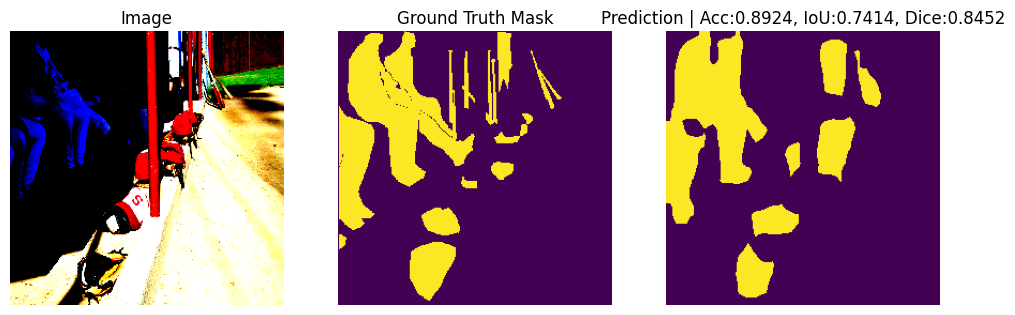

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6051416].


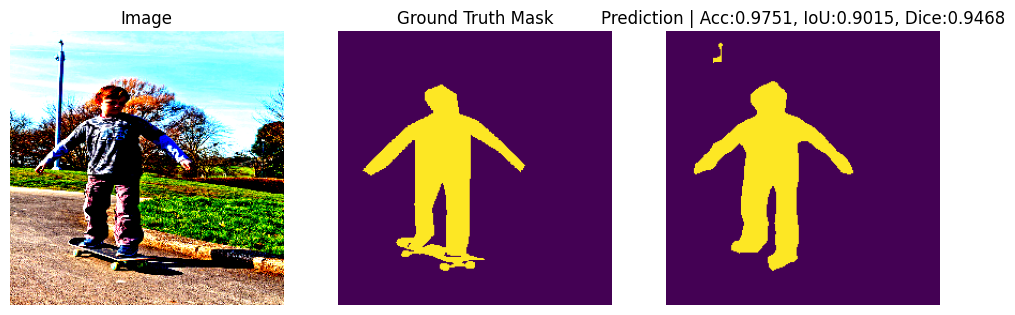

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].


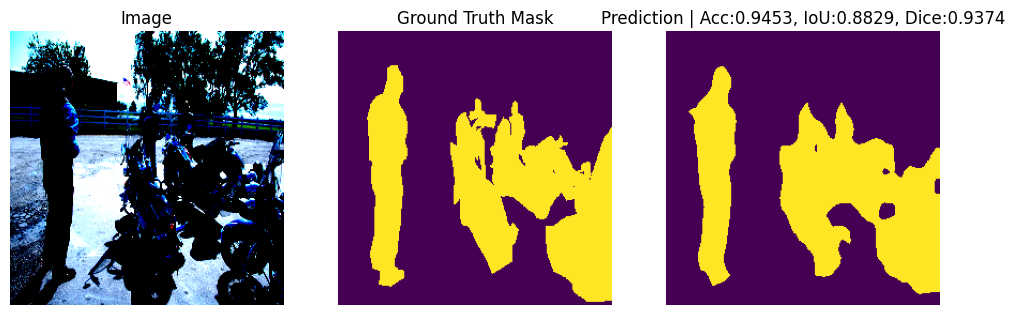

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.9235379].


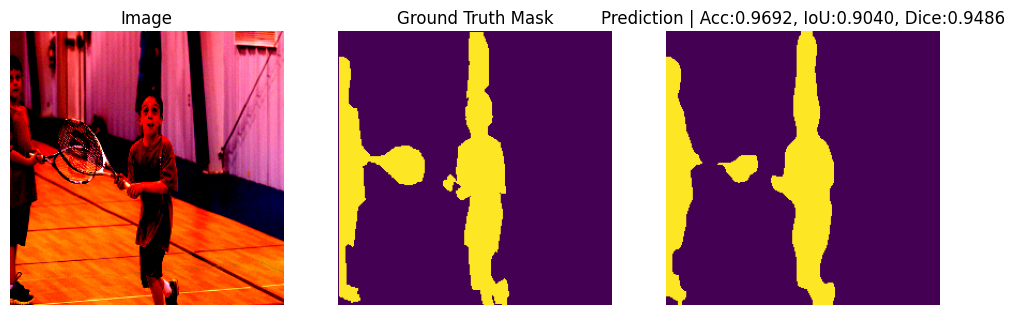

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5354247].


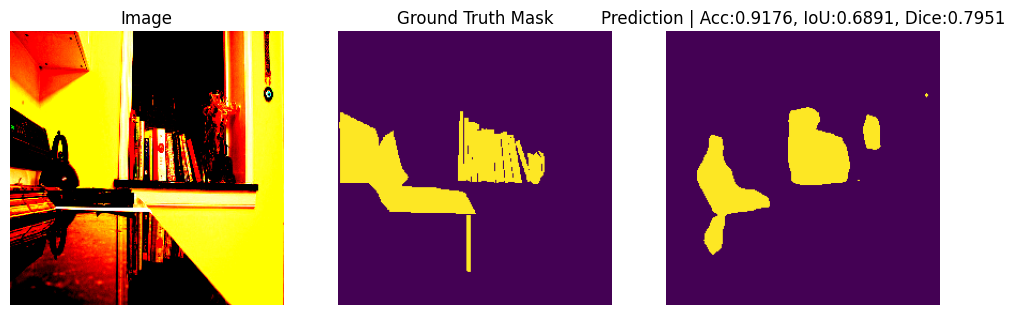

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6041614..2.6399999].


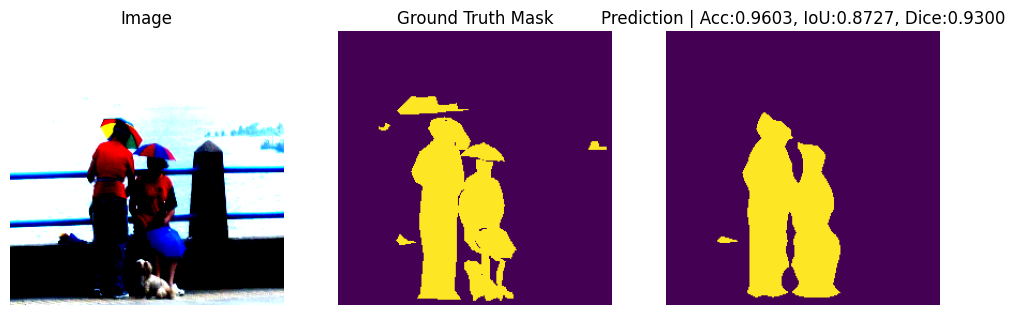

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].


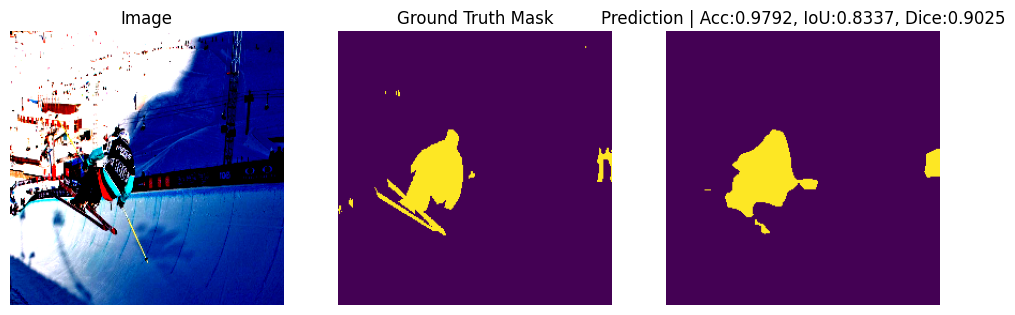

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6051416].


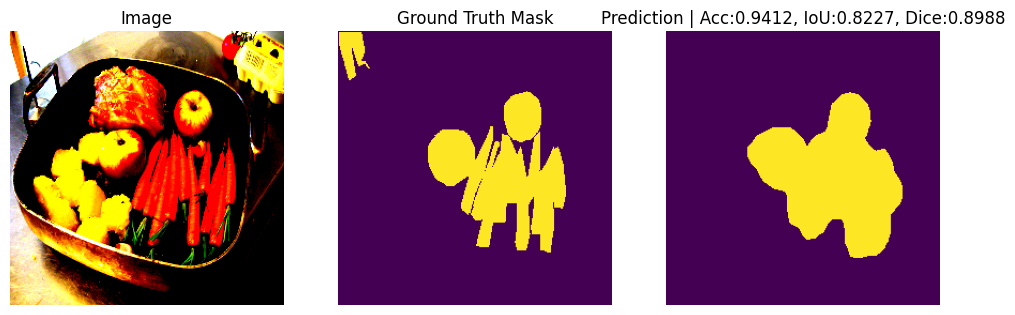

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].


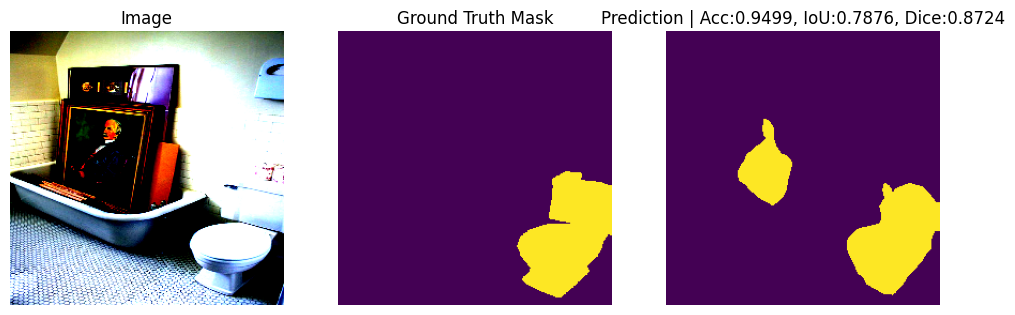

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].


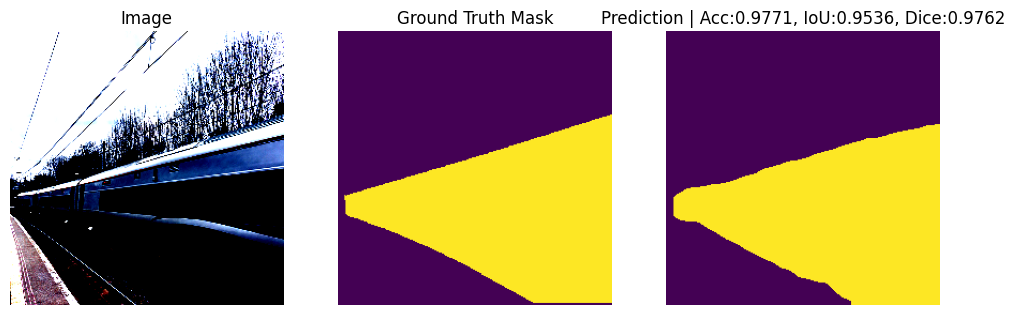

Average Pixel Accuracy: 0.9507354736328125
Average IoU: 0.838922443535606
Average Dice: 0.9052987298656084


In [27]:
import os
import torch
import torchvision
import numpy as np
from torch.utils.data import Dataset
from PIL import Image
from skimage.draw import polygon
import albumentations as A
from albumentations.pytorch import ToTensorV2
import random
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

images_path = r"C:\Users\ilaki\Desktop\VISON_AI\coco2017\val2017"
annotations_path = r"C:\Users\ilaki\Desktop\VISON_AI\coco2017\annotations\instances_val2017.json"
checkpoint_path = r"C:\Users\ilaki\Desktop\VISON_AI\coco2017\deeplabv3_resumed_final_5more.pth"
num_classes = 2
image_size = 256

class CocoMaskedDataset(Dataset):
    def __init__(self, images_path, annotations_path, transform=None):
        self.images_path = images_path
        self.transform = transform
        import json
        with open(annotations_path, "r") as f:
            coco = json.load(f)
        self.images = {img["id"]: img["file_name"] for img in coco["images"]}
        self.annotations = {}
        for ann in coco["annotations"]:
            img_id = ann["image_id"]
            if img_id not in self.annotations:
                self.annotations[img_id] = []
            self.annotations[img_id].append(ann)
        self.ids = list(self.images.keys())

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_id = self.ids[idx]
        img_path = os.path.join(self.images_path, self.images[img_id])
        img = np.array(Image.open(img_path).convert("RGB"))
        mask = np.zeros(img.shape[:2], dtype=np.uint8)
        anns = self.annotations.get(img_id, [])
        for ann in anns:
            for seg in ann["segmentation"]:
                if isinstance(seg, list) and len(seg) % 2 == 0:
                    poly = np.array(seg).reshape(-1, 2)
                    rr, cc = polygon(poly[:,1], poly[:,0], shape=img.shape[:2])
                    mask[rr, cc] = 1
        if self.transform:
            augmented = self.transform(image=img, mask=mask)
            img = augmented["image"]
            mask = augmented["mask"]
        return img, mask

transform = A.Compose([
    A.Resize(image_size, image_size),
    A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
    ToTensorV2()
])

dataset = CocoMaskedDataset(images_path, annotations_path, transform=transform)

model = torchvision.models.segmentation.deeplabv3_resnet50(pretrained=False, aux_loss=True, num_classes=num_classes)
checkpoint = torch.load(checkpoint_path, map_location=device)
state_dict = {k: v for k, v in checkpoint.items() if "aux_classifier" not in k}
model.load_state_dict(state_dict, strict=False)
model.to(device)
model.eval()

def pixel_accuracy(preds, masks):
    preds = torch.argmax(preds, dim=1)
    return (preds == masks).float().mean().item()

def iou_score(preds, masks, num_classes=num_classes):
    preds = torch.argmax(preds, dim=1)
    ious = []
    for cls in range(num_classes):
        intersection = ((preds == cls) & (masks == cls)).sum().item()
        union = ((preds == cls) | (masks == cls)).sum().item()
        ious.append(intersection / (union + 1e-6))
    return np.mean(ious)

def dice_score(preds, masks, num_classes=num_classes):
    preds = torch.argmax(preds, dim=1)
    dices = []
    for cls in range(num_classes):
        intersection = ((preds == cls) & (masks == cls)).sum().item()
        total = (preds == cls).sum().item() + (masks == cls).sum().item()
        dices.append(2*intersection / (total + 1e-6))
    return np.mean(dices)

random_indices = random.sample(range(len(dataset)), 10)
all_pixel_acc, all_iou, all_dice = [], [], []

for idx in random_indices:
    img, mask = dataset[idx]
    img_input = img.unsqueeze(0).to(device)
    mask = mask.to(device)
    with torch.no_grad():
        output = model(img_input)["out"]
    pixel_acc = pixel_accuracy(output, mask)
    iou = iou_score(output, mask)
    dice = dice_score(output, mask)
    all_pixel_acc.append(pixel_acc)
    all_iou.append(iou)
    all_dice.append(dice)
    pred_mask = torch.argmax(output, dim=1).squeeze().cpu().numpy()
    img_np = img.permute(1,2,0).cpu().numpy()
    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1)
    plt.title("Image")
    plt.imshow(img_np)
    plt.axis("off")
    plt.subplot(1,3,2)
    plt.title("Ground Truth Mask")
    plt.imshow(mask.cpu().numpy())
    plt.axis("off")
    plt.subplot(1,3,3)
    plt.title(f"Prediction | Acc:{pixel_acc:.4f}, IoU:{iou:.4f}, Dice:{dice:.4f}")
    plt.imshow(pred_mask)
    plt.axis("off")
    plt.show()

print("Average Pixel Accuracy:", np.mean(all_pixel_acc))
print("Average IoU:", np.mean(all_iou))
print("Average Dice:", np.mean(all_dice))


In [ ]:
import torch
import torch.nn as nn
from torchvision.models.segmentation import deeplabv3_resnet50, DeepLabV3_ResNet50_Weights
import random
import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_classes = 2
checkpoint_path = r"C:\Users\ilaki\Desktop\VISON_AI\coco2017\deeplabv3_resumed_epoch30.pth"

weights = DeepLabV3_ResNet50_Weights.DEFAULT
model = deeplabv3_resnet50(weights=weights, aux_loss=True)
model.classifier[4] = nn.Conv2d(256, num_classes, kernel_size=1)
model.load_state_dict(torch.load(checkpoint_path, map_location=device))
model.to(device)
model.eval()

def unnormalize(img_tensor):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = img_tensor.cpu().numpy().transpose(1,2,0)
    img = (img * std) + mean
    return np.clip(img, 0, 1)

def compute_metrics(pred, mask, num_classes=2):
    pred, mask = pred.cpu().numpy(), mask.cpu().numpy()
    pixel_acc = (pred == mask).mean()
    iou_list, dice_list = [], []
    for cls in range(num_classes):
        inter = np.logical_and(pred==cls, mask==cls).sum()
        union = np.logical_or(pred==cls, mask==cls).sum()
        iou_list.append(inter / (union + 1e-6))
        total = (pred==cls).sum() + (mask==cls).sum()
        dice_list.append(2*inter / (total + 1e-6))
    return pixel_acc, np.mean(iou_list), np.mean(dice_list)

indices = random.sample(range(len(val_dataset)), 10)
pixel_acc_list, iou_list, dice_list = [], [], []

for idx in indices:
    img, mask = val_dataset[idx]
    img, mask = img.to(device), mask.to(device)

    with torch.no_grad():
        output = model(img.unsqueeze(0))["out"]
        pred_mask = torch.argmax(output.squeeze(), dim=0)

    pixel_acc, iou, dice = compute_metrics(pred_mask, mask)
    pixel_acc_list.append(pixel_acc)
    iou_list.append(iou)
    dice_list.append(dice)

    img_np = unnormalize(img)
    mask_np = mask.cpu().numpy()
    pred_np = pred_mask.cpu().numpy()
    overlay = img_np.copy()
    overlay[pred_np == 1] = [1, 0, 0]

    fig, axs = plt.subplots(1, 4, figsize=(20,5))
    axs[0].imshow(img_np)
    axs[0].set_title("Original Image")
    axs[1].imshow(mask_np, cmap='gray')
    axs[1].set_title("Ground Truth Mask")
    axs[2].imshow(pred_np, cmap='gray')
    axs[2].set_title("Predicted Mask")
    axs[3].imshow(overlay)
    axs[3].set_title("Prediction Overlay")
    for ax in axs:
        ax.axis('off')
    plt.show()

print(f"Average Pixel Accuracy: {np.mean(pixel_acc_list):.4f}")
print(f"Average IoU: {np.mean(iou_list):.4f}")
print(f"Average Dice: {np.mean(dice_list):.4f}")


C:\Users\ilaki\AppData\Local\Temp\ipykernel_24060\2029556200.py:93: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=devic

Epoch [1/30] Train Loss: 0.2256 Val Loss: 0.2117 Pixel Acc: 0.9504 IoU: 0.8830 Dice: 0.9365 LR: 0.000010
Best model updated!


Epoch [2/30] Train Loss: 0.2176 Val Loss: 0.2124 Pixel Acc: 0.9498 IoU: 0.8827 Dice: 0.9364 LR: 0.000010


Epoch [3/30] Train Loss: 0.2164 Val Loss: 0.2105 Pixel Acc: 0.9510 IoU: 0.8851 Dice: 0.9378 LR: 0.000010
Best model updated!


Epoch [4/30] Train Loss: 0.2139 Val Loss: 0.2116 Pixel Acc: 0.9506 IoU: 0.8846 Dice: 0.9375 LR: 0.000010


Epoch [5/30] Train Loss: 0.2123 Val Loss: 0.2116 Pixel Acc: 0.9504 IoU: 0.8829 Dice: 0.9364 LR: 0.000010


Epoch [6/30] Train Loss: 0.2116 Val Loss: 0.2110 Pixel Acc: 0.9504 IoU: 0.8835 Dice: 0.9367 LR: 0.000009
Backbone unfrozen, fine-tuning full model!


Epoch [7/30] Train Loss: 0.2067 Val Loss: 0.2049 Pixel Acc: 0.9539 IoU: 0.8914 Dice: 0.9414 LR: 0.000009
Best model updated!


Epoch [8/30] Train Loss: 0.1986 Val Loss: 0.2031 Pixel Acc: 0.9545 IoU: 0.8927 Dice: 0.9422 LR: 0.000009
Best model updated!


Epoch [9/30] Train Loss: 0.1949 Val Loss: 0.2028 Pixel Acc: 0.9546 IoU: 0.8923 Dice: 0.9419 LR: 0.000008
Best model updated!


Epoch [10/30] Train Loss: 0.1915 Val Loss: 0.2032 Pixel Acc: 0.9547 IoU: 0.8933 Dice: 0.9426 LR: 0.000008


Epoch [11/30] Train Loss: 0.1891 Val Loss: 0.2027 Pixel Acc: 0.9549 IoU: 0.8931 Dice: 0.9424 LR: 0.000007
Best model updated!


Epoch [12/30] Train Loss: 0.1867 Val Loss: 0.2021 Pixel Acc: 0.9554 IoU: 0.8951 Dice: 0.9436 LR: 0.000007
Best model updated!


Epoch [13/30] Train Loss: 0.1849 Val Loss: 0.2038 Pixel Acc: 0.9547 IoU: 0.8931 Dice: 0.9423 LR: 0.000007


Epoch [14/30] Train Loss: 0.1827 Val Loss: 0.2029 Pixel Acc: 0.9556 IoU: 0.8954 Dice: 0.9438 LR: 0.000006


Epoch [15/30] Train Loss: 0.1813 Val Loss: 0.2027 Pixel Acc: 0.9554 IoU: 0.8950 Dice: 0.9436 LR: 0.000006


Epoch [16/30] Train Loss: 0.1798 Val Loss: 0.2025 Pixel Acc: 0.9554 IoU: 0.8948 Dice: 0.9435 LR: 0.000005


Epoch [17/30] Train Loss: 0.1783 Val Loss: 0.2031 Pixel Acc: 0.9555 IoU: 0.8949 Dice: 0.9435 LR: 0.000004


Epoch [18/30] Train Loss: 0.1770 Val Loss: 0.2031 Pixel Acc: 0.9557 IoU: 0.8957 Dice: 0.9440 LR: 0.000004


Epoch [19/30] Train Loss: 0.1760 Val Loss: 0.2040 Pixel Acc: 0.9555 IoU: 0.8949 Dice: 0.9435 LR: 0.000003


Epoch [20/30] Train Loss: 0.1749 Val Loss: 0.2052 Pixel Acc: 0.9547 IoU: 0.8934 Dice: 0.9426 LR: 0.000003


 67%|██████▋   | 445/667 [09:36<01:55,  1.92it/s]

In [1]:
import torch

print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("Device count:", torch.cuda.device_count())
    print("Current device:", torch.cuda.current_device())
    print("Device name:", torch.cuda.get_device_name(torch.cuda.current_device()))


CUDA available: True
Device count: 1
Current device: 0
Device name: NVIDIA GeForce RTX 4060 Laptop GPU


C:\Users\ilaki\AppData\Local\Temp\ipykernel_3224\3938056090.py:89: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device

Epoch 1/5 - Train Loss: 0.1552 | Val Pixel Acc: 0.9633 | Val IoU: 0.6133 | Val Dice: 0.6499


Epoch 2/5 - Training: 100%|██████████| 2000/2000 [17:24<00:00,  1.91it/s]


Epoch 2/5 - Train Loss: 0.1034 | Val Pixel Acc: 0.9663 | Val IoU: 0.6157 | Val Dice: 0.6505


Epoch 3/5 - Training: 100%|██████████| 2000/2000 [17:26<00:00,  1.91it/s]


Epoch 3/5 - Train Loss: 0.0851 | Val Pixel Acc: 0.9684 | Val IoU: 0.6291 | Val Dice: 0.6640


Epoch 4/5 - Training: 100%|██████████| 2000/2000 [17:24<00:00,  1.91it/s]


Epoch 4/5 - Train Loss: 0.0746 | Val Pixel Acc: 0.9686 | Val IoU: 0.6317 | Val Dice: 0.6663


Epoch 5/5 - Training: 100%|██████████| 2000/2000 [17:29<00:00,  1.91it/s]


Epoch 5/5 - Train Loss: 0.0664 | Val Pixel Acc: 0.9705 | Val IoU: 0.6329 | Val Dice: 0.6672
Saved: C:\Users\ilaki\Desktop\VISON_AI\ultra_refined_finetuned\000000000139.jpg
Saved: C:\Users\ilaki\Desktop\VISON_AI\ultra_refined_finetuned\000000000285.jpg
Saved: C:\Users\ilaki\Desktop\VISON_AI\ultra_refined_finetuned\000000000632.jpg
Saved: C:\Users\ilaki\Desktop\VISON_AI\ultra_refined_finetuned\000000000724.jpg
Saved: C:\Users\ilaki\Desktop\VISON_AI\ultra_refined_finetuned\000000000776.jpg
Saved: C:\Users\ilaki\Desktop\VISON_AI\ultra_refined_finetuned\000000000785.jpg
Saved: C:\Users\ilaki\Desktop\VISON_AI\ultra_refined_finetuned\000000000802.jpg
Saved: C:\Users\ilaki\Desktop\VISON_AI\ultra_refined_finetuned\000000000872.jpg
Saved: C:\Users\ilaki\Desktop\VISON_AI\ultra_refined_finetuned\000000000885.jpg
Saved: C:\Users\ilaki\Desktop\VISON_AI\ultra_refined_finetuned\000000001000.jpg
Saved: C:\Users\ilaki\Desktop\VISON_AI\ultra_refined_finetuned\000000001268.jpg
Saved: C:\Users\ilaki\Deskto

KeyboardInterrupt: 

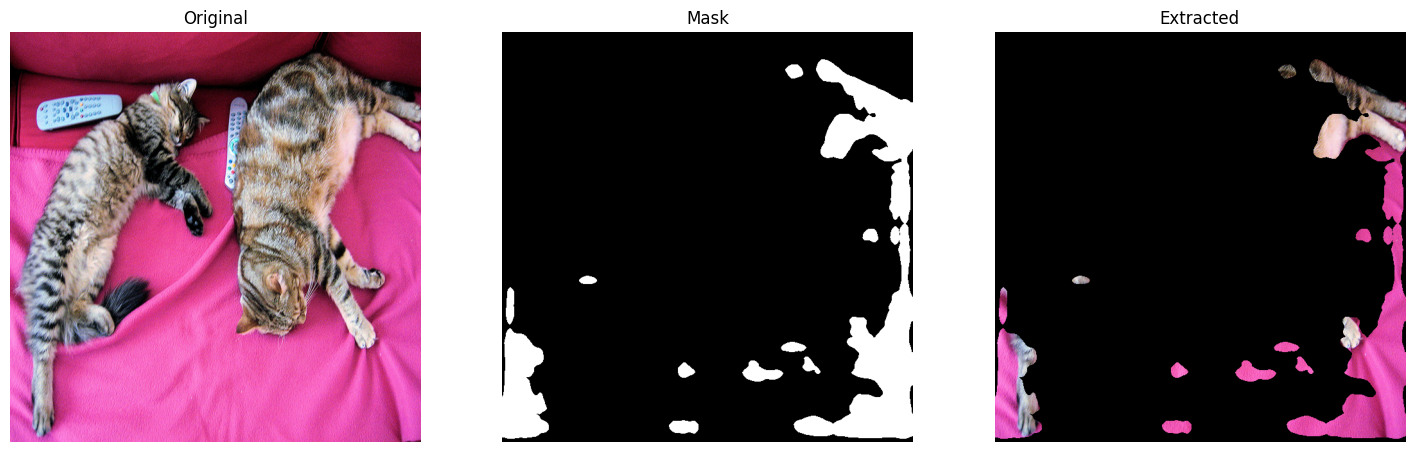

In [15]:
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision.transforms as T
from torchvision.models.segmentation import deeplabv3_resnet50
from skimage.morphology import remove_small_objects, remove_small_holes, closing, disk
from skimage.measure import label
from scipy.ndimage import gaussian_filter, binary_dilation
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -------------------- Paths --------------------
checkpoint_path = r"C:\Users\ilaki\Desktop\VISON_AI\coco2017\deeplabv3_resumed_epoch30.pth"
train_image_dir = r"C:\Users\ilaki\Desktop\VISON_AI\coco2017\val2017"
train_mask_dir = r"C:\Users\ilaki\Desktop\VISON_AI\coco2017\BinaryMasks"
output_dir = r"C:\Users\ilaki\Desktop\VISON_AI\ultra_refined_finetuned"
os.makedirs(output_dir, exist_ok=True)

# -------------------- Hyperparameters --------------------
num_classes = 2
image_size = 640
batch_size = 2
lr = 1e-5
fine_tune_epochs = 5
val_split = 0.2

# -------------------- Dataset --------------------
class SegmentationDataset(Dataset):
    def __init__(self, img_dir, mask_dir, image_size=640, transform=None):
        self.img_paths = sorted([f for f in os.listdir(img_dir) if f.lower().endswith(('.jpg','.png','.jpeg'))])
        self.mask_paths = sorted([f for f in os.listdir(mask_dir) if f.lower().endswith(('.png','.jpg'))])
        
        # Match images and masks
        self.pairs = []
        mask_set = set(os.path.splitext(f)[0] for f in self.mask_paths)
        for img in self.img_paths:
            name = os.path.splitext(img)[0]
            if name in mask_set:
                mask_file = next(f for f in self.mask_paths if os.path.splitext(f)[0] == name)
                self.pairs.append((os.path.join(img_dir, img), os.path.join(mask_dir, mask_file)))

        if len(self.pairs) == 0:
            raise RuntimeError("No matching image-mask pairs found!")

        self.transform = transform
        self.image_size = image_size

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        img_path, mask_path = self.pairs[idx]
        img = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        # Resize both
        img = img.resize((self.image_size, self.image_size))
        mask = mask.resize((self.image_size, self.image_size))

        if self.transform:
            img = self.transform(img)

        mask = torch.from_numpy(np.array(mask) > 0).long()  # binary mask 0/1
        return img, mask

# -------------------- Transforms --------------------
transform = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

dataset = SegmentationDataset(train_image_dir, train_mask_dir, image_size=image_size, transform=transform)

# -------------------- Train/Val Split --------------------
val_size = int(len(dataset) * val_split)
train_size = len(dataset) - val_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

# -------------------- Model --------------------
model = deeplabv3_resnet50(weights=None, aux_loss=False)
model.classifier[4] = nn.Conv2d(256, num_classes, kernel_size=1)
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint, strict=False)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

# -------------------- Metrics --------------------
def compute_metrics(pred, mask, num_classes=2):
    pred, mask = pred.cpu().numpy(), mask.cpu().numpy()
    pixel_acc = (pred == mask).mean()
    iou_list, dice_list = [], []
    for cls in range(num_classes):
        inter = np.logical_and(pred==cls, mask==cls).sum()
        union = np.logical_or(pred==cls, mask==cls).sum()
        iou_list.append(inter / (union + 1e-6))
        total = (pred==cls).sum() + (mask==cls).sum()
        dice_list.append(2*inter / (total + 1e-6))
    return pixel_acc, np.mean(iou_list), np.mean(dice_list)

# -------------------- Ultra-refine functions --------------------
def refine_mask(prob_mask, min_size=150, sigma_small=0.8, sigma_large=1.5, dilate_size=2):
    smoothed = gaussian_filter(prob_mask, sigma=sigma_small)
    smoothed = gaussian_filter(smoothed, sigma=sigma_large)
    threshold = max(0.05, 0.3 * smoothed.max())
    mask = (smoothed > threshold).astype(np.uint8)
    mask = remove_small_objects(mask.astype(bool), min_size=min_size)
    mask = remove_small_holes(mask, area_threshold=min_size)
    labeled = label(mask)
    areas = [np.sum(labeled==i) for i in range(1, labeled.max()+1)]
    for i, area in enumerate(areas):
        if area < 50 and np.sum((labeled==i+1) & mask) > 0:
            mask[labeled==i+1] = True
    mask = closing(mask, disk(2))
    mask = binary_dilation(mask, structure=disk(dilate_size))
    return mask.astype(np.uint8)

def denormalize(img_tensor):
    img = img_tensor.permute(1,2,0).cpu().numpy()
    img = img * np.array([0.229,0.224,0.225]) + np.array([0.485,0.456,0.406])
    return np.clip(img,0,1)

def extract_subject(img_np, mask_bin):
    return img_np * np.expand_dims(mask_bin, axis=-1)

# -------------------- Training Loop --------------------
for epoch in range(fine_tune_epochs):
    model.train()
    running_loss = 0.0
    for imgs, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{fine_tune_epochs} - Training"):
        imgs, masks = imgs.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)["out"]
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)

    # -------------------- Validation --------------------
    model.eval()
    val_pixel_acc, val_iou, val_dice = [], [], []
    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs, masks = imgs.to(device), masks.to(device)
            outputs = model(imgs)["out"]
            preds = torch.argmax(outputs, dim=1)
            pixel_acc, iou, dice = compute_metrics(preds, masks)
            val_pixel_acc.append(pixel_acc)
            val_iou.append(iou)
            val_dice.append(dice)

    print(f"Epoch {epoch+1}/{fine_tune_epochs} - "
          f"Train Loss: {avg_train_loss:.4f} | "
          f"Val Pixel Acc: {np.mean(val_pixel_acc):.4f} | "
          f"Val IoU: {np.mean(val_iou):.4f} | "
          f"Val Dice: {np.mean(val_dice):.4f}")

# -------------------- Inference and Save --------------------
model.eval()
with torch.no_grad():
    for img_path, mask_path in dataset.pairs:
        img = Image.open(img_path).convert("RGB")
        img_resized = img.resize((image_size, image_size))
        img_tensor = transform(img_resized).unsqueeze(0).to(device)
        out = model(img_tensor)["out"].softmax(dim=1).squeeze().cpu().numpy()
        fg_probs = out[1]
        final_mask = refine_mask(fg_probs)
        img_np = denormalize(img_tensor.squeeze())
        extracted = extract_subject(img_np, final_mask)

        fig, axs = plt.subplots(1,3,figsize=(18,8))
        axs[0].imshow(img_np); axs[0].set_title("Original"); axs[0].axis("off")
        axs[1].imshow(final_mask,cmap='gray'); axs[1].set_title("Mask"); axs[1].axis("off")
        axs[2].imshow(extracted); axs[2].set_title("Extracted"); axs[2].axis("off")
        plt.tight_layout()
        save_path = os.path.join(output_dir, os.path.basename(img_path))
        fig.savefig(save_path, dpi=300)
        plt.close(fig)
        print(f"Saved: {save_path}")


C:\Users\ilaki\AppData\Local\Temp\ipykernel_3224\3240023471.py:71: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device

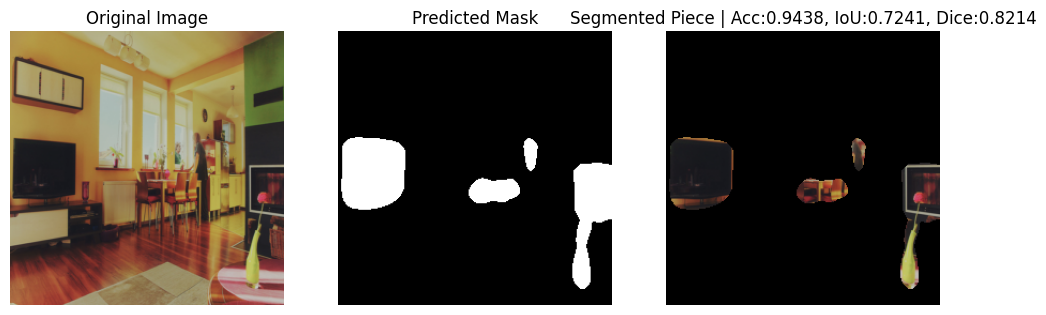

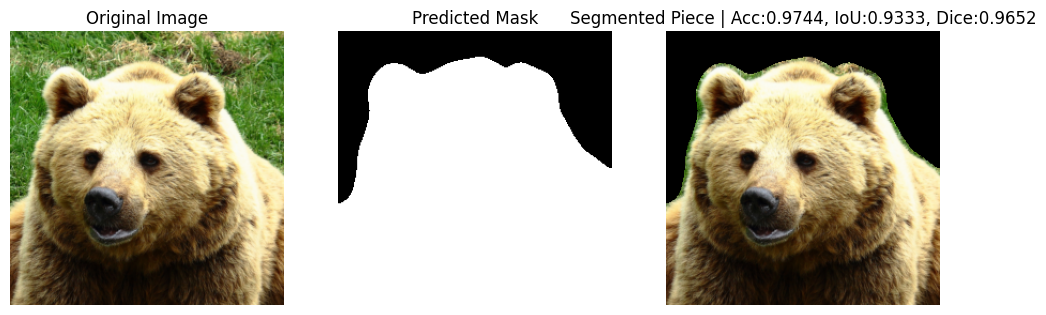

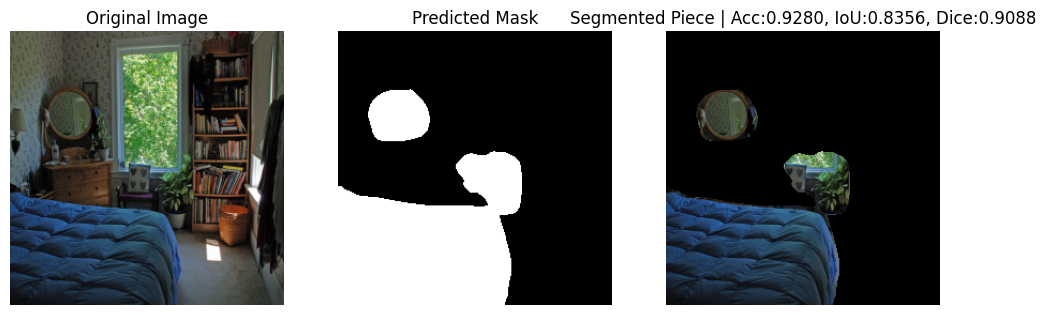

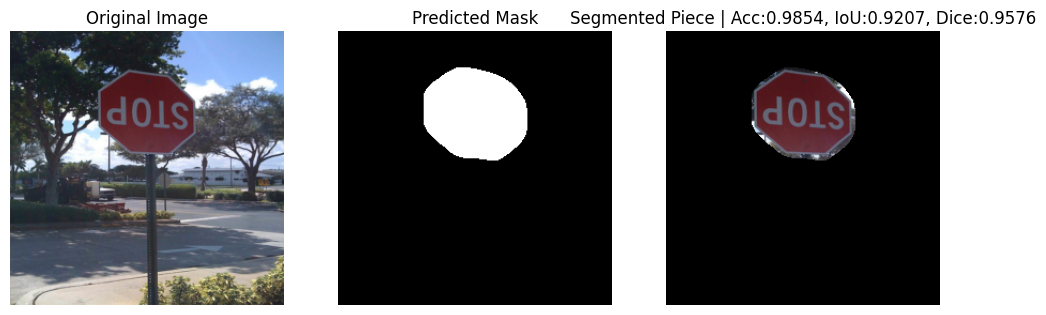

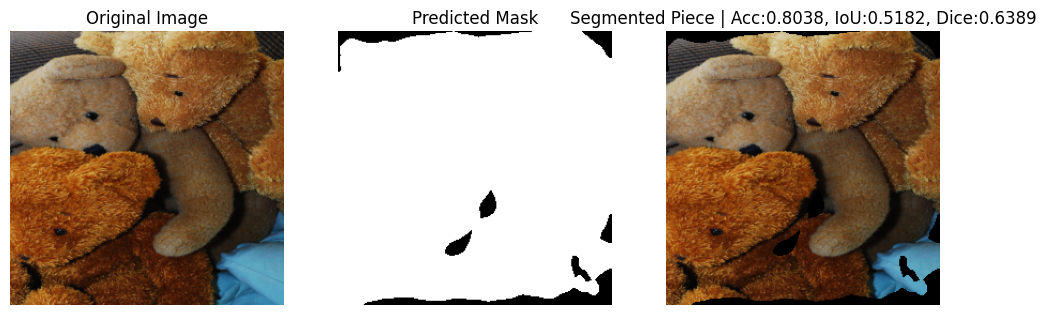

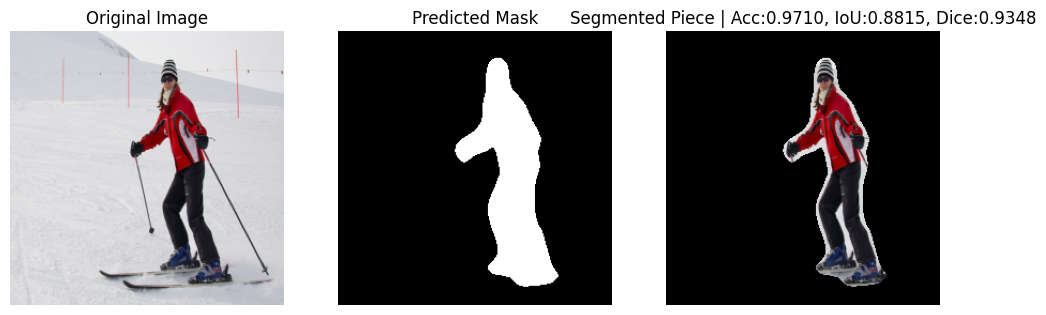

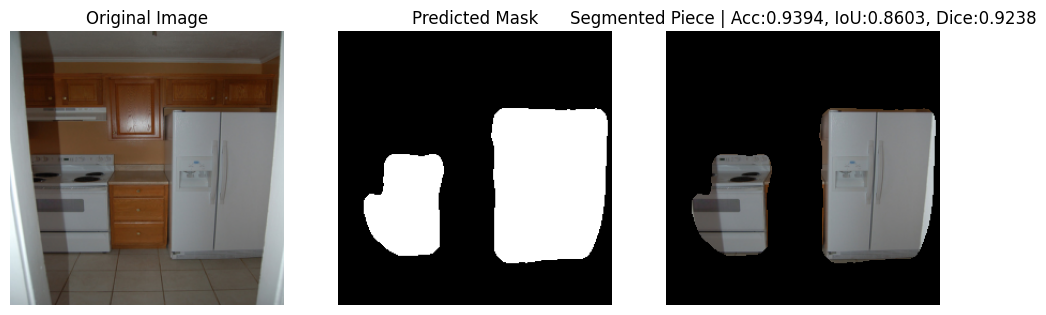

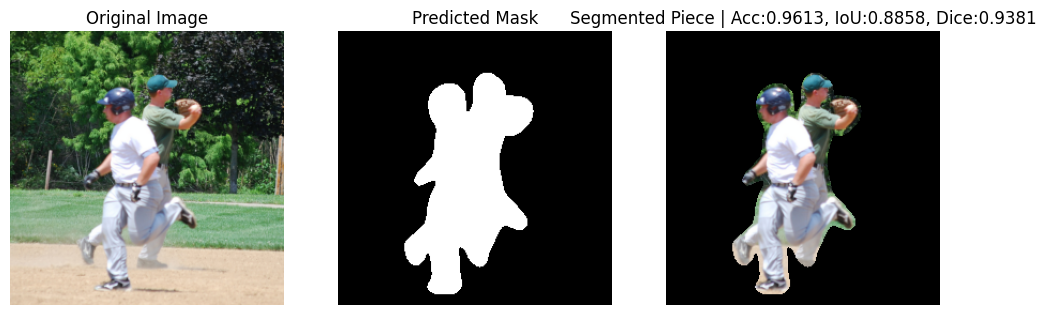

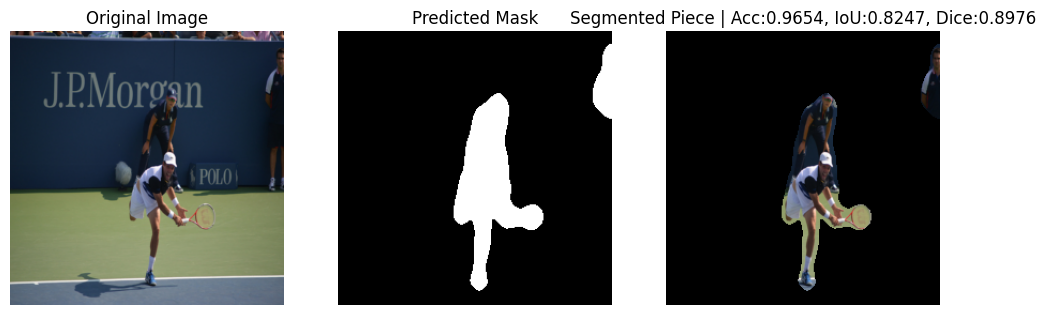

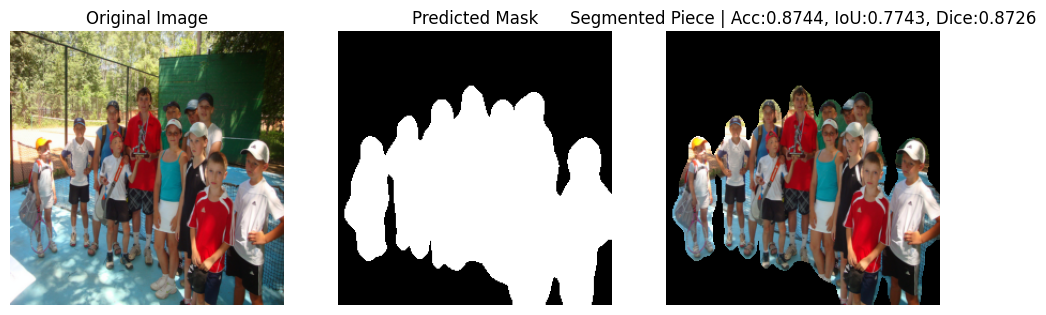

In [21]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from skimage.morphology import remove_small_objects, remove_small_holes, closing, disk
from scipy.ndimage import gaussian_filter, binary_dilation
from torchvision import transforms
import torchvision

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---- Paths ----
images_path = r"C:\Users\ilaki\Desktop\VISON_AI\coco2017\val2017"
checkpoint_path = r"C:\Users\ilaki\Desktop\VISON_AI\coco2017\deeplabv3_resumed_epoch30.pth"
num_classes = 2
image_size = 256

# ---- Mask refinement ----
def refine_mask(prob_mask, min_size=150, sigma_small=0.8, sigma_large=1.5, dilate_size=2):
    smoothed = gaussian_filter(prob_mask, sigma=sigma_small)
    smoothed = gaussian_filter(smoothed, sigma=sigma_large)
    threshold = max(0.05, 0.3 * smoothed.max())
    mask = (smoothed > threshold).astype(np.uint8)
    mask = remove_small_objects(mask.astype(bool), min_size=min_size)
    mask = remove_small_holes(mask, area_threshold=min_size)
    mask = closing(mask, disk(2))
    mask = binary_dilation(mask, structure=disk(dilate_size))
    return mask.astype(np.uint8)

# ---- TTA inference ----
def tta_inference(model, img_tensor, scales=[1.0, 0.75, 1.25], flips=[None, 'h', 'v']):
    model.eval()
    device = img_tensor.device
    _, C, H, W = img_tensor.shape
    agg_output = torch.zeros((1, num_classes, H, W), device=device)

    for scale in scales:
        if scale != 1.0:
            new_H, new_W = int(H*scale), int(W*scale)
            scaled_img = torch.nn.functional.interpolate(img_tensor, size=(new_H,new_W), mode='bilinear', align_corners=False)
        else:
            scaled_img = img_tensor

        for f in flips:
            if f == 'h':
                inp = torch.flip(scaled_img, dims=[3])
            elif f == 'v':
                inp = torch.flip(scaled_img, dims=[2])
            else:
                inp = scaled_img

            with torch.no_grad():
                out = model(inp)["out"]

            if f == 'h':
                out = torch.flip(out, dims=[3])
            elif f == 'v':
                out = torch.flip(out, dims=[2])

            if scale != 1.0:
                out = torch.nn.functional.interpolate(out, size=(H,W), mode='bilinear', align_corners=False)

            agg_output += out

    agg_output /= (len(scales) * len(flips))
    return agg_output

# ---- Load model ----
model = torchvision.models.segmentation.deeplabv3_resnet50(pretrained=False, aux_loss=True, num_classes=num_classes)
checkpoint = torch.load(checkpoint_path, map_location=device)
state_dict = {k: v for k, v in checkpoint.items() if "aux_classifier" not in k}
model.load_state_dict(state_dict, strict=False)
model.to(device)
model.eval()

# ---- Image transforms ----
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225))
])

def denormalize(img_tensor):
    img = img_tensor.permute(1,2,0).cpu().numpy()
    img = img * np.array([0.229,0.224,0.225]) + np.array([0.485,0.456,0.406])
    return np.clip(img,0,1)

# ---- Metrics ----
def pixel_accuracy(preds, masks):
    preds = torch.argmax(preds, dim=1)
    return (preds == masks).float().mean().item()

def iou_score(preds, masks, num_classes=2):
    preds = torch.argmax(preds, dim=1)
    ious = []
    for cls in range(num_classes):
        intersection = ((preds == cls) & (masks == cls)).sum().item()
        union = ((preds == cls) | (masks == cls)).sum().item()
        ious.append(intersection / (union + 1e-6))
    return np.mean(ious)

def dice_score(preds, masks, num_classes=2):
    preds = torch.argmax(preds, dim=1)
    dices = []
    for cls in range(num_classes):
        intersection = ((preds == cls) & (masks == cls)).sum().item()
        total = (preds == cls).sum().item() + (masks == cls).sum().item()
        dices.append(2*intersection / (total + 1e-6))
    return np.mean(dices)

# ---- Run Inference + Extract Segment ----
image_files = [f for f in os.listdir(images_path) if f.lower().endswith(('.jpg','.png','.jpeg'))]

for img_name in image_files[:10]:  # first 10 images
    img_path = os.path.join(images_path, img_name)
    img_pil = Image.open(img_path).convert("RGB")
    img_tensor = transform(img_pil).unsqueeze(0).to(device)

    output = tta_inference(model, img_tensor)
    prob_mask = torch.softmax(output, dim=1)[0,1].cpu().numpy()
    final_mask = refine_mask(prob_mask)

    img_np = denormalize(img_tensor[0])

    # ---- Extract segmented piece ----
    segmented = img_np.copy()
    segmented[final_mask==0] = 0  # zero out background

    # ---- Metrics ----
    mask_tensor = torch.tensor(final_mask).unsqueeze(0).to(device)
    pixel_acc = pixel_accuracy(output, mask_tensor)
    iou = iou_score(output, mask_tensor)
    dice = dice_score(output, mask_tensor)

    # ---- Show ----
    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1)
    plt.title("Original Image")
    plt.imshow(img_np)
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.title("Predicted Mask")
    plt.imshow(final_mask, cmap='gray')
    plt.axis("off")

    plt.subplot(1,3,3)
    plt.title(f"Segmented Piece | Acc:{pixel_acc:.4f}, IoU:{iou:.4f}, Dice:{dice:.4f}")
    plt.imshow(segmented)
    plt.axis("off")
    plt.show()
